In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, ThreatSearch,
    Heuristics, GomokuTools as gt, create_sample, create_samples_and_qvalues)

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [5]:
import pandas as pd
df = pd.read_csv("self_play_games-1.csv")
game = df['game'][0]
game

'i10h9j9h11k10j10g6m12l9m8m6i12k9m9i8h7k8l7'

In [6]:
stones = gt.string_to_stones(game)
stones = [(ord(x)-64, y) for x,y in stones]
stones

[(9, 10),
 (8, 9),
 (10, 9),
 (8, 11),
 (11, 10),
 (10, 10),
 (7, 6),
 (13, 12),
 (12, 9),
 (13, 8),
 (13, 6),
 (9, 12),
 (11, 9),
 (13, 9),
 (9, 8),
 (8, 7),
 (11, 8),
 (12, 7)]

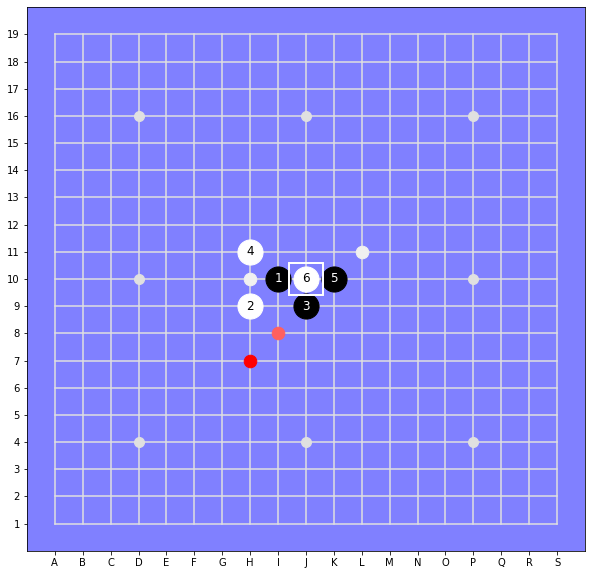

In [7]:
size=19
until = 6
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5)
heuristics = Heuristics(kappa=3.0)
board = GomokuBoard(N=size, stones=stones[:until], disp_width=10, heuristics=heuristics)
board.display(probas=lambda x: p.probas(x, 2))

### Creating policy samples

In [8]:
viewpoint = BLACK if len(stones)%2 == 0 else WHITE
sample = create_sample(N=size, stones=stones[:until], viewpoint=viewpoint)

np.rollaxis(sample, 2, 0)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
probas = p.probas(board, 2)

probas = np.hstack([
    np.zeros([size+2,1], dtype=np.uint8), 
    np.vstack([np.zeros(size, dtype=np.uint8), 
               probas, 
               np.zeros(size, dtype=np.uint8)]),
    np.zeros([size+2,1], dtype=np.uint8)
])
probas.shape

(21, 21)

In [10]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

1.13.1


False

In [11]:
class ResNet:
    """
    After sufficient training, this instance of ResNet takes an array of dimensions 10x10 
    and returns 1 if the array contains the pattern you tought it to recognize.
    """
    def __init__(self, size, n_blocks):
        
        self.inps = tf.placeholder(name="inp_resnet", 
                                   shape=[None, size+2, size+2, 2], dtype=tf.float32)
        self.lbls = tf.placeholder(name="lbl_resnet", 
                                   shape=[None, size+2, size+2, 1], dtype=tf.float32)

        out = self.inps

        for i in range(n_blocks):
            out = self._res_block(out)

        self.out = tf.layers.conv2d(kernel_size=1, filters=1, inputs=out, 
                               padding='same', activation=None)

        lbls_1dim = tf.reshape(self.lbls, [-1, 21*21, 1])
        outs_1dim = tf.reshape(self.out, [-1, 21*21, 1])
        self.loss = tf.losses.softmax_cross_entropy(lbls_1dim, outs_1dim)
        
        self.errors = tf.losses.mean_squared_error(self.lbls, self.out)
        self.accuracy=tf.reduce_sum(tf.cast(self.errors < .1, dtype=tf.int64))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        self.trainer = self.optimizer.minimize(self.errors)
    
    
    def _res_block(self, inp, filters=16, activation='elu'):
      
        out1_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1 = tf.concat([out1_3, out1_5], axis=3)
        
        out2_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2 = tf.concat([out2_3, out2_5], axis=3)
        
        out3_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3 = tf.concat([out3_3, out3_5], axis=3)
        
        bn = tf.layers.batch_normalization(inputs=out3)

        skip = tf.layers.conv2d(kernel_size=1, filters=2, inputs=inp, 
                                padding='same', activation=None)
        
        return tf.concat([skip, bn], axis=3)

In [12]:
resnet = ResNet(n_blocks=10, size=19)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


In [13]:
lbl = probas.reshape(-1, 21, 21, 1)
smp = sample.reshape(-1, 21, 21, 2)

In [14]:
sess.close()

NameError: name 'sess' is not defined

In [17]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
loss, acc, pred, err, _ = sess.run([resnet.loss, resnet.accuracy, resnet.out, 
                                    resnet.errors, resnet.trainer], 
                          feed_dict={resnet.inps: smp, resnet.lbls: lbl})
err

0.11537095

In [19]:
samples = create_samples_and_qvalues(board, p, heuristics)

In [20]:
smp, _, _, lbl = samples

In [21]:
smp.shape, lbl.shape

((8, 21, 21, 2), (8, 21, 21, 1))

In [22]:
from wgomoku import to_matrix12
ind = 2
lbl_i = lbl[ind].reshape(21,21)
lbl_i = lbl_i[1:-1].T[1:-1].T
m12 = to_matrix12(smp[ind], size=21)
m12

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [27]:
for i in range(201):
    loss, acc, pred, err, _ = sess.run([resnet.loss, resnet.accuracy, resnet.out, 
                                        resnet.errors, resnet.trainer], 
                              feed_dict={resnet.inps: smp, resnet.lbls: lbl})
    if i % 20 == 0:
        print (err)


0.0003100602
0.00027943283
0.0002540222
0.0002326201
0.00021437011
0.00019864787
0.00018498005
0.00017300091
0.0001624232
0.00015302023
0.0001446108


In [28]:
pred.shape, lbl_i.shape

((8, 21, 21, 1), (19, 19))

In [29]:
pred_i = pred[ind].reshape(21,21)
pred_i = pred_i[1:-1].T[1:-1].T
pred_i.shape

(19, 19)

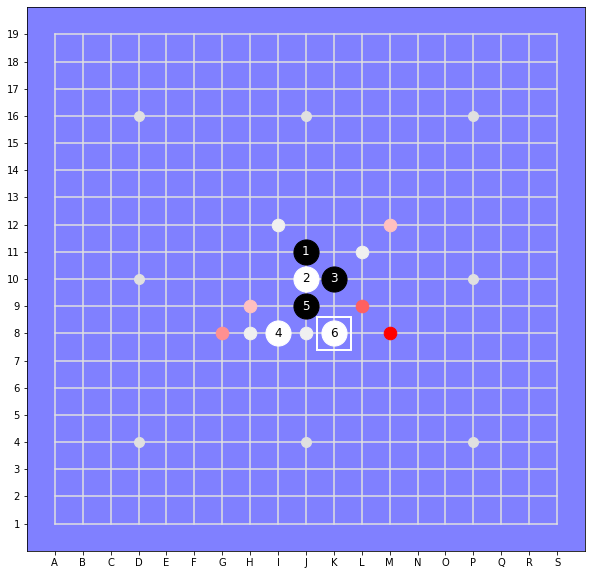

In [30]:
black = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 1]
white = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 2]
pairs = zip(black, white)

moves = []
for b,w in pairs: 
    moves.append(b)
    moves.append(w)
board = GomokuBoard(N=19, stones=moves, heuristics=heuristics, disp_width=10)
board.display(probas=lambda x: pred_i)

In [33]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(101):
        l, o, _ = sess.run([resnet.loss, resnet.out, resnet.trainer], 
                           feed_dict={resnet.lbls: lbl, resnet.inps: smp})
        if i % 10 == 0:
            print("training loss %s: " % l)
            
            acc, pred, err = sess.run([resnet.accuracy, resnet.out, resnet.errors], 
                                      feed_dict={resnet.inps: smp, resnet.lbls: lbl})
            print("Accuracy %s" % acc)


training loss 0.0: 
Accuracy 281
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
training loss 0.0: 
Accuracy 0
